![picture](data/amer_sign2.png)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

import tensorflow as tf

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [16]:
train = pd.read_csv('data/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('data/sign_mnist_test/sign_mnist_test.csv')

In [17]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [18]:
train.shape, test.shape

((27455, 785), (7172, 785))

<Axes: ylabel='count'>

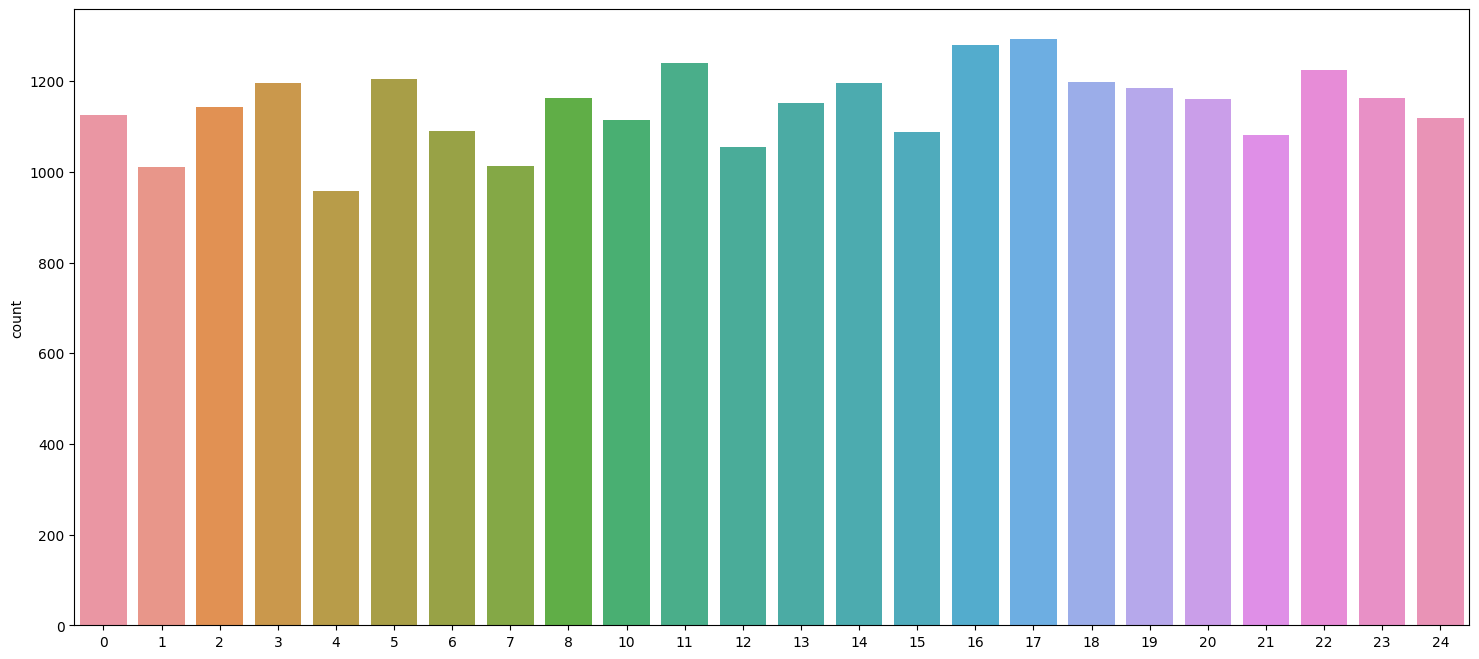

In [19]:

plt.figure(figsize=(18,8))
sbn.countplot(x=train['label'].values)

In [20]:
y_train =train['label']
y_test =test['label']
x_train=train.drop('label',axis=1)
x_test=test.drop('label',axis=1)

In [21]:
x_train = x_train / 255
x_test = x_test / 255

In [22]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_test=lb.fit_transform(y_test)

In [23]:
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

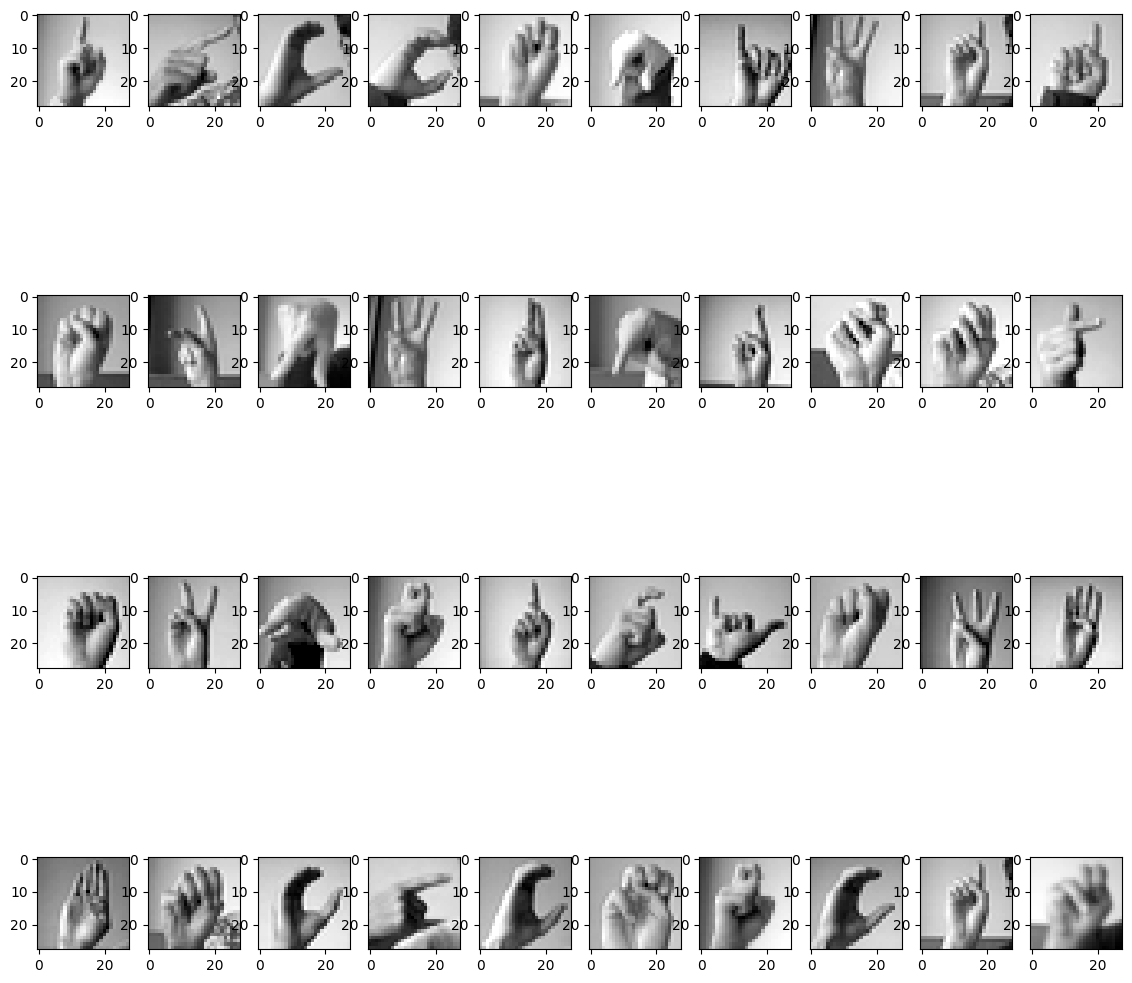

In [24]:
plt.figure(figsize=(14,14))
x, y = 10, 4 
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
plt.show()

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [27]:
model = Sequential()   
model.add(Conv2D(35,
                 kernel_size=(3,3),   ## kernel size nedir
                 activation='relu',
                 input_shape=(28,28,1),
                 strides = 1 ,
                 padding = 'same'))

model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),
                    strides = 2 , 
                    padding = 'same'))

model.add(Conv2D(50,
                 kernel_size=(3,3),
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),
                    strides=2,
                    padding='same'))
model.add(Flatten())
model.add(Dense(units=24,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 35)        350       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 35)       140       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 35)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 50)        15800     
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 50)      

In [28]:
with tf.device('/GPU:0'):
    history = model.fit(datagen.flow(x_train,y_train,batch_size=128),epochs=20, validation_data=(x_test,y_test), callbacks=[learning_rate_reduction])

Epoch 1/20


2023-05-26 15:11:01.372690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


215/215 [==============================] - 13s 55ms/step - loss: 1.1573 - accuracy: 0.6546 - val_loss: 2.7538 - val_accuracy: 0.1378 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 11s 53ms/step - loss: 0.3563 - accuracy: 0.8853 - val_loss: 1.2274 - val_accuracy: 0.6405 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 11s 53ms/step - loss: 0.1980 - accuracy: 0.9372 - val_loss: 0.5918 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 11s 52ms/step - loss: 0.1331 - accuracy: 0.9574 - val_loss: 1.6248 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 11s 52ms/step - loss: 0.0967 - accuracy: 0.9691 - val_loss: 0.0872 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 11s 53ms/step - loss: 0.0732 - accuracy: 0.9778 - val_loss: 0.0987 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 11s 53ms/step -

In [29]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 1s 3ms/step - loss: 0.0198 - accuracy: 0.9944
Accuracy of the model is -  99.44227337837219 %


In [30]:
model.save('new_sign_model.h5')
print('model saved')

model saved


In [31]:
x_test

array([[[[0.58431373],
         [0.58431373],
         [0.58823529],
         ...,
         [0.58823529],
         [0.58823529],
         [0.58431373]],

        [[0.58823529],
         [0.58823529],
         [0.58823529],
         ...,
         [0.59215686],
         [0.58823529],
         [0.59215686]],

        [[0.58823529],
         [0.59215686],
         [0.59215686],
         ...,
         [0.59215686],
         [0.59215686],
         [0.59607843]],

        ...,

        [[0.27058824],
         [0.27058824],
         [0.30196078],
         ...,
         [0.45490196],
         [0.44313725],
         [0.4627451 ]],

        [[0.29019608],
         [0.29411765],
         [0.29803922],
         ...,
         [0.43137255],
         [0.45490196],
         [0.44313725]],

        [[0.29411765],
         [0.29019608],
         [0.29019608],
         ...,
         [0.43921569],
         [0.47058824],
         [0.41960784]]],


       [[[0.49411765],
         [0.50196078],
         [0.51

In [32]:

predictions = model.predict(x_test)
predictions=np.argmax(predictions,axis=1)
predictions +=1


225/225 [==============================] - 1s 3ms/step


((7172,), (7172, 28, 28, 1))

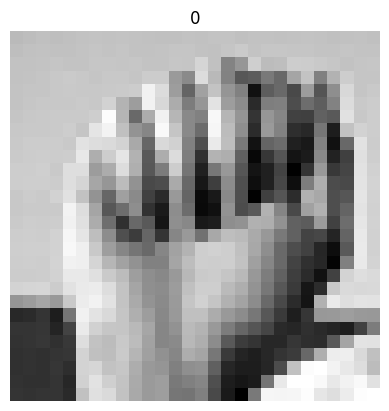

tf.Tensor(
[[[[255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]]

  [[255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]]

  [[255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]]

  [[255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   [255.]
   